In [1]:
from typing import Any, Optional, List

import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent, PositionsTracker
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal

from qubx.utils.charting.lookinglass import LookingGlass
from qubx import QubxLogConfig
from qubx.backtester import simulate, variate
from qubx.core.metrics import tearsheet, chart_signals, get_symbol_pnls
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer
from qubx.core.metrics import chart_signals
from qubx.trackers.riskctrl import AtrRiskTracker
from qubx.data.helpers import load_data


START = "2024-01-01"
STOP = "2024-05-01"


def __sim(config: dict, reader, symbols: list[str] | None = None, timeframe: str = "1h", fit: str | None = None, start: str = START, stop: str = STOP, silent: bool = True):
    if symbols is None:
        symbols = ["BINANCE.UM:BTCUSDT", "BINANCE.UM:ETHUSDT", "BINANCE.UM:XRPUSDT"]
    return simulate(
        config,
        data=reader,
        capital=10000,
        instruments=symbols,
        subscription=dict(type="ohlc", timeframe=timeframe, nback=0),
        trigger="-1Sec",
        fit=fit,
        commissions="vip0_usdt",
        start=start,
        stop=stop,
        silent=silent
    )



⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. 0.2.2
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [4]:
r = MultiQdbConnector("xlydian-data")

## 1.0 Reference experiment with fixed universe

In [21]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1h"
    fast_period = 5
    slow_period = 12
    atr_tp: float | None = None
    atr_sl: float | None = 5

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return AtrRiskTracker(
            self.atr_tp, self.atr_sl, self.timeframe, 50, atr_smoother="kama", sizer=FixedRiskSizer(0.5)
        )

  0%|          | 0/6 [00:00<?, ?it/s]

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
5,"/SFT_(t=1h,fp=20,sp=100)",1065.884754,0.353935,2.287089,2.779416,5.119566,575.435278,4.872535,7.170813,1.847156,0.803888,108.542898,0.085577,94.125653,107.0
2,"/SFT_(t=1h,fp=10,sp=100)",260.835880,0.080082,0.634960,0.233438,8.520053,921.099981,1.180418,1.108408,1.162739,0.233440,113.981829,0.023605,122.048004,149.0
4,"/SFT_(t=1h,fp=20,sp=50)",-432.151080,-0.123806,-0.936617,-0.415224,9.142085,951.418875,-1.536146,-1.650638,1.111590,0.358936,116.443610,-0.033836,180.002968,225.0
1,"/SFT_(t=1h,fp=10,sp=50)",-946.061776,-0.257209,-2.291145,-1.596941,10.911679,1105.406751,-3.696453,-2.712563,1.040549,0.678857,116.196383,-0.079264,198.911672,252.0
0,"/SFT_(t=1h,fp=10,sp=25)",-1343.263202,-0.350505,-3.405840,-7.141608,14.832914,1498.700061,-5.206811,-2.538650,0.779367,0.953968,118.254646,-0.116063,313.739202,392.0
3,"/SFT_(t=1h,fp=20,sp=25)",-1916.518138,-0.470882,-5.271725,-8.153070,21.097943,2158.799861,-7.587370,-2.339254,0.774444,0.959648,119.523118,-0.172309,404.167427,512.0


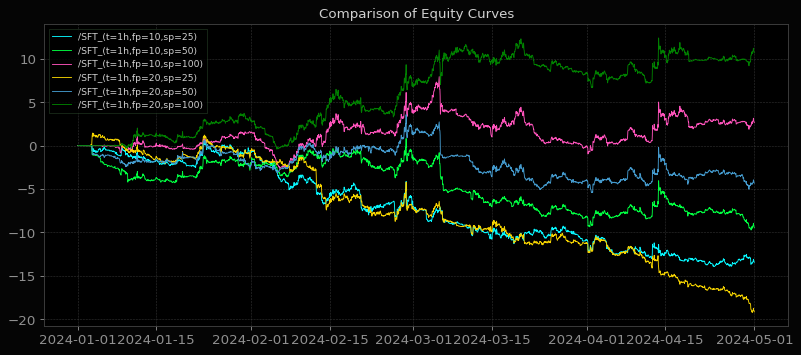

In [30]:
QubxLogConfig.set_log_level("ERROR")

timeframe = "1h"

symbols = ["BTCUSDT", "ETHUSDT", "XRPUSDT"]
exchange = "BINANCE.UM"

instruments = [f"{exchange}:{s}" for s in symbols]

rep = __sim(
    variate(
        StrategyForTracking,
        timeframe=[timeframe],
        fast_period=[10, 20],
        slow_period=[25, 50, 100],
        conditions=lambda fast_period, slow_period: fast_period < slow_period,
    ),
    r,
    symbols=instruments,
)

tearsheet(rep)

In [ ]:
symbol = "BTCUSDT"
start = "2024-01-01"
stop = "2024-05-01"

ohlc = load_data(r, exchange, symbol, start, stop, timeframe=timeframe, transform=AsOhlcvSeries())[symbol]

fast = sma(ohlc.close, 20)
slow = sma(ohlc.close, 100)

chart_signals(rep[5], symbol, ohlc=ohlc, timeframe=timeframe, start=start, end=stop, overlay=[fast.pd(), slow.pd()])

## 2.0 Apply top volume universe filter

In [6]:
class CrossingsWithUniverseV2(IStrategy):
    timeframe: str = "1h"
    fast_period = 5
    slow_period = 12
    atr_tp: float | None = None
    atr_sl: float | None = 5

    universe_lookback: str = "30d"
    universe_size: int = 10

    def __init__(self, **kwargs: Any):
        super().__init__(**kwargs)
        self.qdb = MultiQdbConnector("xlydian-data")
        self.exchange = "BINANCE.UM"

    def on_fit(
        self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None
    ):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")
        fit_time = pd.Timestamp(fit_time)
        _start = fit_time - pd.Timedelta(self.universe_lookback)

        quote_volume = self.qdb.get_average_quote_volume(self.exchange, _start, fit_time, timeframe="1d")
        top_volume = quote_volume.head(self.universe_size)
        _symbols = list(top_volume.index)

        logger.info(f" -> Universe: {_symbols}")

        instruments = [lookup.find_symbol(self.exchange, symbol.upper()) for symbol in _symbols]
        instruments = [i for i in instruments if i is not None]

        if instruments:
            ctx.set_universe(instruments)

    def on_universe_change(
        self, ctx: StrategyContext, add_instruments: list[Instrument], rm_instruments: list[Instrument]
    ) -> None:
        add_symbols = [i.symbol for i in add_instruments]
        rm_symbols = [i.symbol for i in rm_instruments]
        logger.info(f" -> Universe change: \n\tadd=<green>{add_symbols}</green>, rm=<red>{rm_symbols}</red>")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)

            if len(fast) < 2 or len(slow) < 2:
                continue

            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return AtrRiskTracker(
            self.atr_tp, self.atr_sl, self.timeframe, 50, atr_smoother="kama", sizer=FixedRiskSizer(0.5)
        )

In [13]:
QubxLogConfig.set_log_level("INFO")

timeframe = "1h"

symbols = ["BTCUSDT"]
exchange = "BINANCE.UM"

instruments = [f"{exchange}:{s}" for s in symbols]

rep3 = __sim(
    variate(
        CrossingsWithUniverseV2,
        timeframe=[timeframe],
        fast_period=[20],
        slow_period=[100],
    ),
    r,
    symbols=instruments,
    fit="@monthly",
    start="2023-01-01",
)

2024-08-14 12:25:34.899 [ ℹ️ ] CrossingsWithUniverseV2 new parameters:
	set timeframe <- 1h
	set fast_period <- 20
	set slow_period <- 100
2023-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized
2023-01-01 00:00:00.000 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1h', 'nback': 0} for 
	['BTCUSDT'] 
2023-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2023-01-01
2023-01-01 00:00:00.000 [ ℹ️ ] Initializing chunks for each loader
2023-01-01 00:00:00.001 [ ℹ️ ]  -> Fit is called | fit_time: 2022-12-01 00:00:00 / prev: None
2023-01-01 00:00:00.001 [ ℹ️ ]  -> Universe: ['btcusdt', 'ethusdt', 'dogeusdt', 'solusdt', 'maticusdt', 'bnbusdt', 'maskusdt', 'xrpusdt', 'chzusdt', 'ltcusdt']
2023-01-01 00:00:00.001 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1h', 'nback': 0} for 
	['MASKUSDT', 'ETHUSDT', 'LTCUSDT', 'BNBUSDT', 'CHZUSDT', 'MATICUSDT', 'DOGEUSDT', 'XRPUSDT', 'SOLUSDT'] 
2023-01-01 00

In [14]:
tearsheet(rep3)

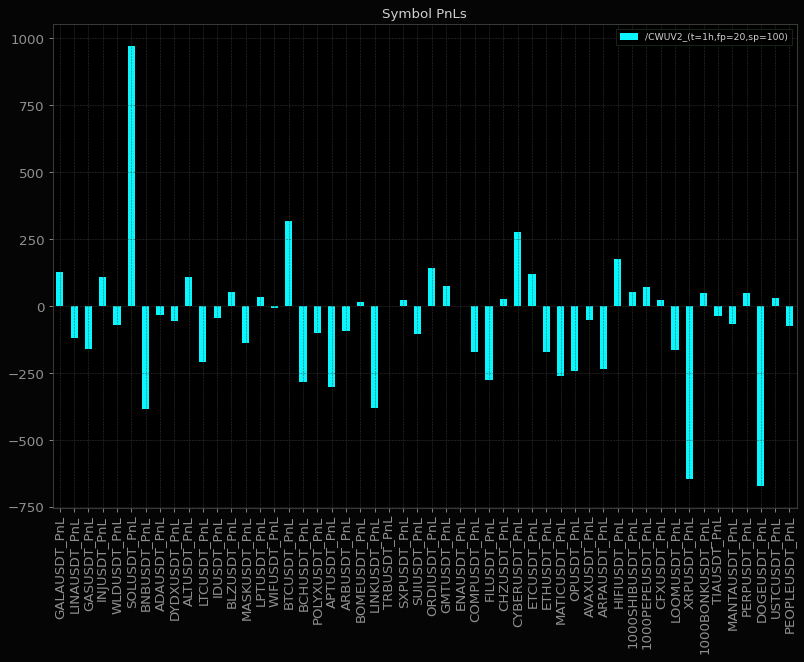

In [15]:
get_symbol_pnls(rep3).T.plot(kind="bar", figsize=(12, 8), title="Symbol PnLs");

In [16]:
rep3[0].signals_log.groupby("instrument_id").signal.count().sort_values(ascending=False)

instrument_id
BTCUSDT         181
ETHUSDT         167
XRPUSDT         163
SOLUSDT         152
DOGEUSDT        116
BNBUSDT          60
BCHUSDT          53
LTCUSDT          46
SUIUSDT          46
LINKUSDT         42
1000PEPEUSDT     40
ARBUSDT          40
MATICUSDT        37
APTUSDT          34
WLDUSDT          30
LINAUSDT         24
ORDIUSDT         23
GASUSDT          23
TRBUSDT          21
FILUSDT          21
MASKUSDT         20
OPUSDT           20
CYBERUSDT        19
1000SHIBUSDT     19
ARPAUSDT         14
COMPUSDT         13
CFXUSDT          13
POLYXUSDT        12
TIAUSDT          12
AVAXUSDT         12
LOOMUSDT         12
MANTAUSDT        10
GMTUSDT          10
IDUSDT           10
INJUSDT          10
CHZUSDT           9
DYDXUSDT          9
WIFUSDT           8
PEOPLEUSDT        8
BOMEUSDT          8
SXPUSDT           7
ADAUSDT           7
ALTUSDT           7
BLZUSDT           7
LPTUSDT           7
PERPUSDT          7
ETCUSDT           7
GALAUSDT          7
USTCUSDT          6
HIFIUS

In [18]:
symbol = "WIFUSDT"
start = "2024-01-01"
stop = "2024-05-01"

ohlc = load_data(r, exchange, symbol, start, stop, timeframe=timeframe, transform=AsOhlcvSeries())[symbol]

fast = sma(ohlc.close, 20)
slow = sma(ohlc.close, 100)

chart_signals(rep3[0], symbol, ohlc=ohlc, timeframe=timeframe, start=start, end=stop, overlay=[fast.pd(), slow.pd()])

## MISC

<Axes: title={'center': 'Top symbols by volume'}, xlabel='symbol'>

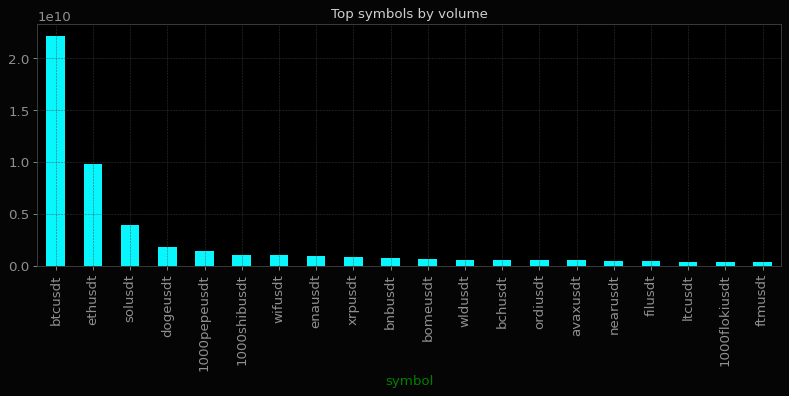

In [234]:
r.get_average_quote_volume("BINANCE.UM", "2024-03-01", "2024-05-10", "1d").head(20).plot(
    kind="bar", figsize=(12, 4), title="Top symbols by volume"
)

In [238]:
r.get_candles(
    "BINANCE.UM",
    ["BTCUSDT", "ETHUSDT", "XRPUSDT", "WIFUSDT", "ADAUSDT", "ICXUSDT", "SRMUSDT", "EGLUSDT"],
    "2024-01-01",
    "2024-05-10",
    "1h",
)

open        high         low       close  \
timestamp           symbol                                                    
2024-01-01 00:00:00 xrpusdt      0.6157      0.6176      0.6151      0.6166   
                    srmusdt      0.2870      0.2870      0.2870      0.2870   
                    icxusdt      0.2673      0.2698      0.2633      0.2691   
                    ethusdt   2283.8400   2299.1600   2282.9700   2297.4100   
                    btcusdt  42314.0000  42603.2000  42289.6000  42503.5000   
...                                 ...         ...         ...         ...   
2024-05-09 23:00:00 srmusdt      0.2870      0.2870      0.2870      0.2870   
                    icxusdt      0.2305      0.2309      0.2289      0.2296   
                    ethusdt   3053.4800   3054.6900   3026.9700   3034.7500   
                    btcusdt  63252.7000  63321.4000  62830.6000  63050.1000   
                    adausdt      0.4632      0.4639      0.4612      0.4633   

                                   volume  quote_volume   count  \
timestamp           symbol                                        
2024-01-01 00:00:00 xrpusdt  2.558607e+07  1.577440e+07   21285   
                    srmusdt  0.000000e+00  0.000000e+00       0   
                    icxusdt  6.020588e+06  1.604998e+06   13924   
                    ethusdt  7.559318e+04  1.733996e+08   75195   
                    btcusdt  8.459479e+03  3.591964e+08   88278   
...                                   ...           ...     ...   
2024-05-09 23:00:00 srmusdt  0.000000e+00  0.000000e+00       0   
                    icxusdt  8.717130e+05  2.003171e+05    2199   
                    ethusdt  6.863626e+04  2.084559e+08  110886   
                    btcusdt  9.630116e+03  6.069666e+08  145953   
                    adausdt  1.245003e+07  5.758102e+06   16159   

                             taker_buy_volume  taker_buy_quote_volume  
timestamp           symbol                                             
2024-01-01 00:00:00 xrpusdt      1.254250e+07            7.732974e+06  
                    srmusdt      0.000000e+00            0.000000e+00  
                    icxusdt      3.012231e+06            8.037859e+05  
                    ethusdt      4.029125e+04            9.241520e+07  
                    btcusdt      4.687978e+03            1.990339e+08  
...                                       ...                     ...  
2024-05-09 23:00:00 srmusdt      0.000000e+00            0.000000e+00  
                    icxusdt      5.598050e+05            1.286563e+05  
                    ethusdt      3.558164e+04            1.080327e+08  
                    btcusdt      4.898351e+03            3.087156e+08  
                    adausdt      7.547281e+06            3.490708e+06  

[21418 rows x 9 columns]